In [27]:
import pandas as pd
import numpy as np
import datetime
from datetime import date, timedelta
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import statsmodels.api as sm

pio.templates.default = "plotly_white"

import zipfile

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
! pip install -U kaleido

In [29]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
from IPython.display import Image
import plotly.io as pio
pio.renderers.default = "png"

# Подготовка данных

Источник данных: https://www.kaggle.com/datasets/ilkeryildiz/example-dataset-for-ab-test/code

In [30]:
zip_path = '/content/drive/MyDrive/analytics/archive.zip'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall('/content')

control_data = pd.read_csv('control_group.csv', sep=';')
test_data = pd.read_csv('test_group.csv', sep=';')

Переименуем колонки более удобным способом:

In [31]:
control_data.columns = ["Campaign Name", "Date", "Amount Spent",
                        "Number of Impressions", "Reach", "Website Clicks",
                        "Searches Received", "Content Viewed", "Added to Cart",
                        "Purchases"]
test_data.columns = ["Campaign Name", "Date", "Amount Spent",
                        "Number of Impressions", "Reach", "Website Clicks",
                        "Searches Received", "Content Viewed", "Added to Cart",
                        "Purchases"]

In [32]:
control_data.head()

,Campaign Name,Date,Amount Spent,Number of Impressions,Reach,Website Clicks,Searches Received,Content Viewed,Added to Cart,Purchases
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Control Campaign,2.08.2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
2,Control Campaign,3.08.2019,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0
3,Control Campaign,4.08.2019,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0
4,Control Campaign,5.08.2019,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
test_data.head()

,Campaign Name,Date,Amount Spent,Number of Impressions,Reach,Website Clicks,Searches Received,Content Viewed,Added to Cart,Purchases
0,Test Campaign,1.08.2019,3008,39550,35820,3038,1946,1069,894,255
1,Test Campaign,2.08.2019,2542,100719,91236,4657,2359,1548,879,677
2,Test Campaign,3.08.2019,2365,70263,45198,7885,2572,2367,1268,578
3,Test Campaign,4.08.2019,2710,78451,25937,4216,2216,1437,566,340
4,Test Campaign,5.08.2019,2297,114295,95138,5863,2106,858,956,768


**Колонки:**

1. **Campaign Name** -- название кампании.
2. **Date** -- дата записи.
3. **Amount Spent** -- сумма, потраченная на кампанию (в долларах).
4. **Number of Impressions**-- количество показов рекламы в рамках кампании.
5. **Reach** -- количество уникальных показов рекламы в рамках кампании, полученных в объявлении.
6. **Website Clicks** -- количество кликов по веб-сайту, полученных с помощью рекламы.
7. **Searches Recieved** -- количество пользователей, выполнивших поиск на веб-сайте.
8. **Content Viewed** -- количество пользователей, которые просматривали контент и продукты на веб-сайте.
9. **Added to Cart** -- количество пользователей, добавивших товары в корзину.
10. **Purchases** -- количество покупок.

Проверим наличие пропущенных значений:

In [34]:
control_data.isnull().sum()

Campaign Name            0
Date                     0
Amount Spent             0
Number of Impressions    1
Reach                    1
Website Clicks           1
Searches Received        1
Content Viewed           1
Added to Cart            1
Purchases                1
dtype: int64

In [35]:
test_data.isnull().sum()

Campaign Name            0
Date                     0
Amount Spent             0
Number of Impressions    0
Reach                    0
Website Clicks           0
Searches Received        0
Content Viewed           0
Added to Cart            0
Purchases                0
dtype: int64

Заменим пропущенные значения в данных:

In [36]:
control_data['Number of Impressions'].fillna(value=control_data['Number of Impressions'].mean(),
                                             inplace=True)
control_data['Reach'].fillna(value=control_data['Reach'].mean(),
                             inplace=True)
control_data['Website Clicks'].fillna(value=control_data['Website Clicks'].mean(),
                                      inplace=True)
control_data['Searches Received'].fillna(value=control_data['Searches Received'].mean(),
                                         inplace=True)
control_data['Content Viewed'].fillna(value=control_data['Content Viewed'].mean(),
                                      inplace=True)
control_data['Added to Cart'].fillna(value=control_data['Added to Cart'].mean(),
                                     inplace=True)
control_data['Purchases'].fillna(value=control_data['Purchases'].mean(),
                                 inplace=True)

Объединим датасеты и сделаем сортировку по датам в порядке возрастания:

In [37]:
ab_data = control_data.merge(test_data, how='outer').sort_values(['Date'])
ab_data = ab_data.reset_index(drop=True)
ab_data.head()

<ipython-input-37-2692c5ccd25d>:1: UserWarning:

You are merging on int and float columns where the float values are not equal to their int representation.



,Campaign Name,Date,Amount Spent,Number of Impressions,Reach,Website Clicks,Searches Received,Content Viewed,Added to Cart,Purchases
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Test Campaign,1.08.2019,3008,39550.0,35820.0,3038.0,1946.0,1069.0,894.0,255.0
2,Test Campaign,10.08.2019,2790,95054.0,79632.0,8125.0,2312.0,1804.0,424.0,275.0
3,Control Campaign,10.08.2019,2149,117624.0,91257.0,2277.0,2475.0,1984.0,1629.0,734.0
4,Test Campaign,11.08.2019,2420,83633.0,71286.0,3750.0,2893.0,2617.0,1075.0,668.0


Проверим, равны ли выборки:

In [38]:
ab_data['Campaign Name'].value_counts()

Campaign Name
Control Campaign    30
Test Campaign       30
Name: count, dtype: int64

Преобразуем колонку Date в формат 'datetime':

In [39]:
ab_data['Date'] = pd.to_datetime(ab_data['Date'], format='%d.%m.%Y')

Проверим типы данных:

In [40]:
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Campaign Name          60 non-null     object        
 1   Date                   60 non-null     datetime64[ns]
 2   Amount Spent           60 non-null     int64         
 3   Number of Impressions  60 non-null     float64       
 4   Reach                  60 non-null     float64       
 5   Website Clicks         60 non-null     float64       
 6   Searches Received      60 non-null     float64       
 7   Content Viewed         60 non-null     float64       
 8   Added to Cart          60 non-null     float64       
 9   Purchases              60 non-null     float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 4.8+ KB


# EDA

**1. Проверим суммарный охват рекламы в рамках обеих кампаниях:**

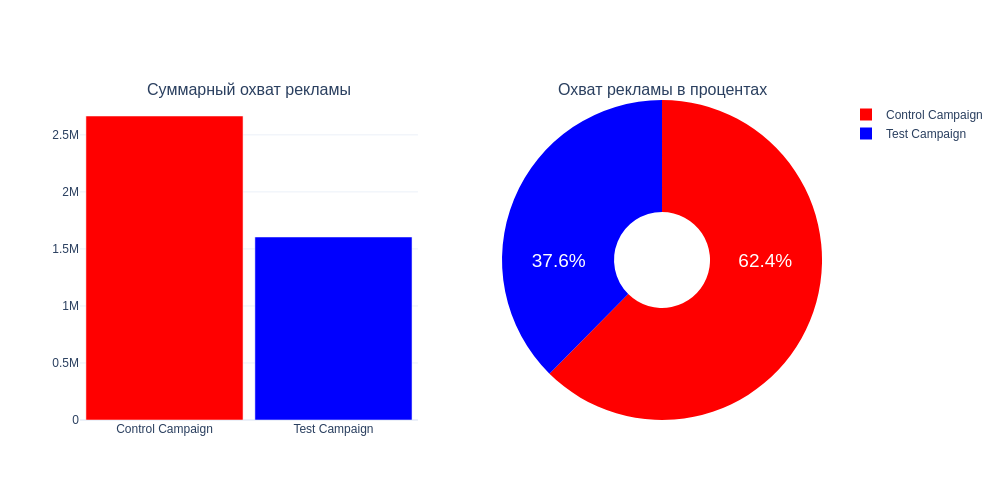

In [41]:
reach_data = ab_data.groupby('Campaign Name')['Reach'].sum()

fig = make_subplots(rows=1, cols=2,
                    subplot_titles=('Суммарный охват рекламы', 'Охват рекламы в процентах'),
                    specs=[[{"type": "xy"}, {"type": "domain"}]])

# Столбчатая диаграмма
fig.add_trace(go.Bar(
    x=reach_data.index,
    y=reach_data,
    textposition='outside',
    marker=dict(color=['red', 'blue']),
    width=0.93,
    showlegend=False
), row=1, col=1)

fig.add_trace(go.Pie(
    labels=reach_data.index,
    values=reach_data,
    textinfo='percent',
    insidetextorientation='radial',
    marker=dict(colors=['red', 'blue']),
    hole=0.3,
    textfont=dict(size=19)
), row=1, col=2)

fig.update_layout(
    height=500,
    width=1000
)

fig.show()

Видим, что в контрольной группе количество уникальных показов рекламы гораздо больше.

**2. Посмотрим на количество переходов на сайте (Website clicks) и охватов (Reach) для сравнения контрольной и тестовой кампаний.** Построим графики эмпирической функции распределения.

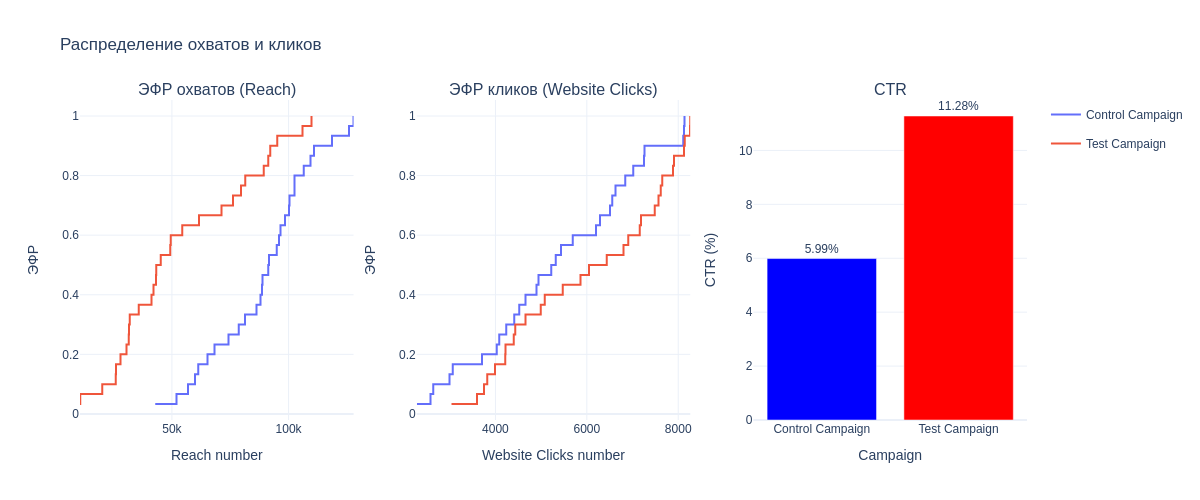

In [42]:
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=['ЭФР охватов (Reach)', 'ЭФР кликов (Website Clicks)', 'CTR'],
    specs=[[{'type':'scatter'}, {'type':'scatter'}, {'type':'xy'}]]
)

fig1 = px.ecdf(
    ab_data,
    x='Reach',
    color='Campaign Name',
    title='ЭФР охватов (Reach)'
)
for trace in fig1.data:
  fig.add_trace(trace, row=1, col=1)

fig2 = px.ecdf(
    ab_data,
    x='Website Clicks',
    color='Campaign Name',
    title='ЭФР кликов (Website Clicks)'
)
for trace in fig2.data:
  trace.showlegend = False
  fig.add_trace(trace, row=1, col=2)

ctr_data = ab_data.groupby(['Campaign Name'])['Website Clicks'].sum() / ab_data.groupby(['Campaign Name'])['Reach'].sum()*100

fig.add_trace(go.Bar(
    x=ctr_data.index,
    y=ctr_data,
    text=ctr_data.apply(lambda x: '{:.2f}%'.format(x)),
    textposition='outside',
    marker=dict(color=["blue", "red"]),
    width=0.8,
    showlegend=False
), row=1, col=3)

fig.update_layout(
    height=500,
    width=1200,
    title_text='Распределение охватов и кликов'
)

fig.update_xaxes(title_text="Reach number", row=1, col=1)
fig.update_yaxes(title_text="ЭФР", row=1, col=1)
fig.update_xaxes(title_text="Website Clicks number", row=1, col=2)
fig.update_yaxes(title_text="ЭФР", row=1, col=2)
fig.update_xaxes(title_text="Campaign", row=1, col=3)
fig.update_yaxes(title_text="CTR (%)", row=1, col=3)

fig.show()

* Совокупное распределение охвата у контрольной группы больше, чем у тестовой.
* Тестовая и контрольные кампании имеют одинаковое распределение кликов на 90%-ом уровне и выше.
* Показатель кликабельности (CTR) у тестовой группы выше, чем у контрольной, несмотря на то, что число показов (Reach) у контрольной группы больше.

Эмпирические распределения для других признаков:

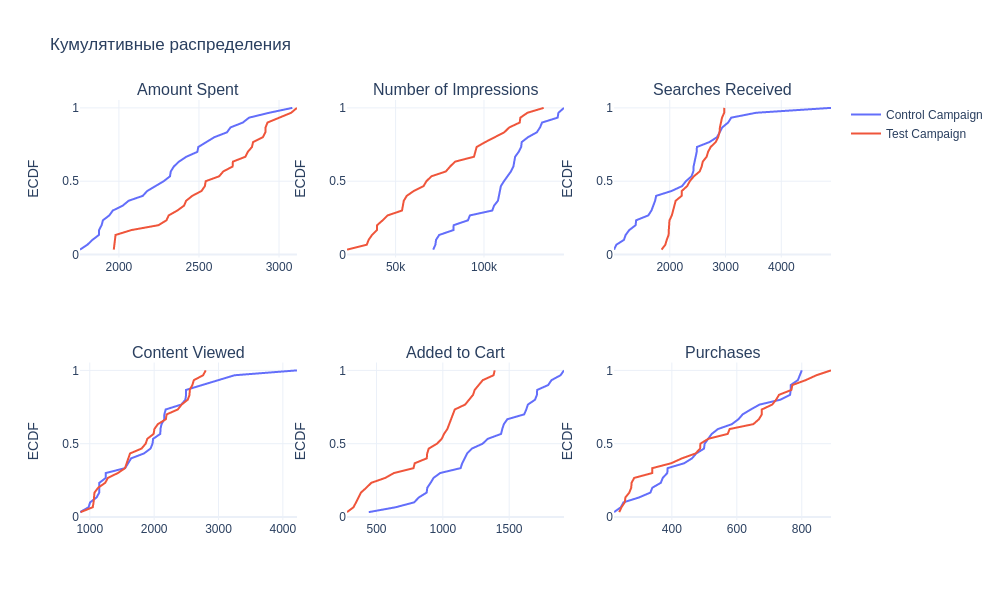

In [43]:
cols = ("Amount Spent", "Number of Impressions", "Searches Received", "Content Viewed", "Added to Cart", "Purchases")
fig = make_subplots(rows=2, cols=3, subplot_titles=cols)

row = 1
col = 1

campaigns = ab_data['Campaign Name'].unique()
colors = px.colors.qualitative.Plotly

added_campaigns = {}

for col_name in cols:
    for i, campaign in enumerate(campaigns):
        if campaign not in added_campaigns:
            showlegend = True
            added_campaigns[campaign] = True
        else:
            showlegend = False

        grouped_df = ab_data[ab_data['Campaign Name'] == campaign]
        ecdf_x, ecdf_y = px.ecdf(grouped_df[col_name]).data[0]['x'], px.ecdf(grouped_df[col_name]).data[0]['y']

        fig.add_trace(go.Scatter(x=ecdf_x, y=ecdf_y, mode='lines', name=campaign,
                                 line=dict(color=colors[i % len(colors)]), showlegend=showlegend),
                      row=row, col=col)

    fig.update_yaxes(title_text='ECDF', row=row, col=col)

    col += 1
    if col > 3:
        col = 1
        row += 1

fig.update_layout(
    height=600,
    width=1000,
    title_text="Кумулятивные распределения"
)

fig.show()

Результаты контрольной группы несколько выше практически по всем метрикам за исключением количества покупок, которые выше в тестовой кампании начиная с 86% уровня.

**3. Посмотрим на корреляции признаков:**

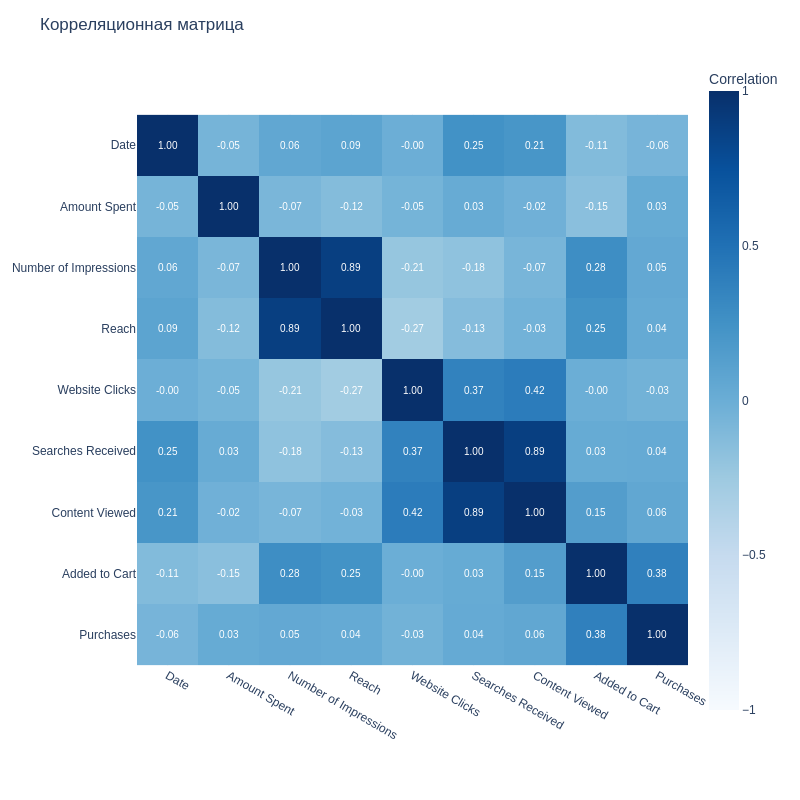

In [44]:
corr_matr = ab_data.drop('Campaign Name', axis=1).corr()
fig = px.imshow(corr_matr,
                labels=dict(color='Correlation'),
                x=corr_matr.columns,
                y=corr_matr.columns,
                color_continuous_scale='Blues',
                zmin=-1, zmax=1)
fig.update_layout(
    title="Корpеляционная матрица",
    width=800,
    height=800
)

for i in range(len(corr_matr.columns)):
  for j in range(len(corr_matr.columns)):
    fig.add_annotation(x=corr_matr.columns[j],
                       y=corr_matr.columns[i],
                       text=f"{corr_matr.iloc[i, j]:.2f}",
                       showarrow=False,
                       font=dict(size=10, color='white'))

fig.show()

* Высокая корреляция между количеством показов рекламы и количеством уникальных показов (Number of Impressions и Reach) ожидаема, так как признаки взаимосвязаны.

* Высокая положительная корреляция между количеством пользователей, совершивших поиск на веб-сайте, и количеством пользователей, просмотревших контент и продукты (Searches Received и Content Viewed).


Для относительно высоких значений корреляций на карте рассмотрим графики для контрольной и тестовой кампании отдельно:

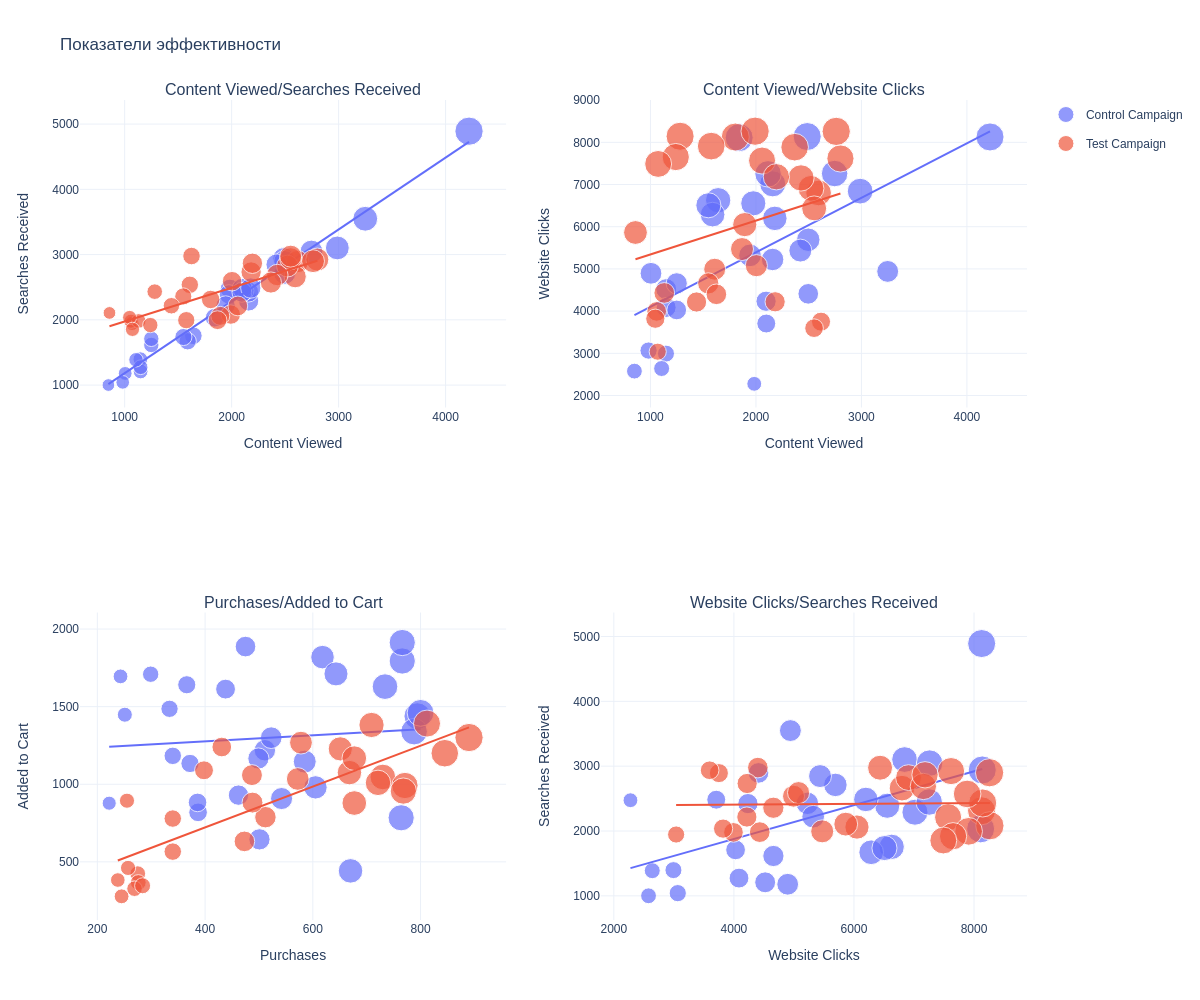

In [45]:
figure1 = px.scatter(data_frame=ab_data,
                    x='Content Viewed',
                    y='Searches Received',
                    size='Content Viewed',
                    color='Campaign Name',
                    trendline='ols')

figure2 = px.scatter(data_frame=ab_data,
                    x='Content Viewed',
                    y='Website Clicks',
                    size='Website Clicks',
                    color='Campaign Name',
                    trendline='ols')

figure3 = px.scatter(data_frame=ab_data,
                    x="Purchases",
                    y="Added to Cart",
                    size="Purchases",
                    color="Campaign Name",
                    trendline="ols")

figure4 = px.scatter(data_frame=ab_data,
                    x='Website Clicks',
                    y='Searches Received',
                    size='Website Clicks',
                    color='Campaign Name',
                    trendline='ols')


fig = make_subplots(rows=2, cols=2, subplot_titles=(
    'Content Viewed/Searches Received',
    'Content Viewed/Website Clicks',
    'Purchases/Added to Cart',
    'Website Clicks/Searches Received'
), specs=[[{'type': 'scatter'}, {'type': 'scatter'}],
          [{'type': 'scatter'}, {'type': 'scatter'}]])


for trace in figure1.data:
  fig.add_trace(trace, row=1, col=1)

for trace in figure2.data:
  trace.showlegend = False
  fig.add_trace(trace, row=1, col=2)

for trace in figure3.data:
  trace.showlegend = False
  fig.add_trace(trace, row=2, col=1)

for trace in figure4.data:
  trace.showlegend = False
  fig.add_trace(trace, row=2, col=2)

fig.update_xaxes(title_text="Content Viewed", row=1, col=1)
fig.update_yaxes(title_text="Searches Received", row=1, col=1)
fig.update_xaxes(title_text="Content Viewed", row=1, col=2)
fig.update_yaxes(title_text="Website Clicks", row=1, col=2)
fig.update_xaxes(title_text="Purchases", row=2, col=1)
fig.update_yaxes(title_text="Added to Cart", row=2, col=1)
fig.update_xaxes(title_text="Website Clicks", row=2, col=2)
fig.update_yaxes(title_text="Searches Received", row=2, col=2)

fig.update_layout(title_text="Показатели эффективности",
                  height=1000,
                  width=1200)

fig.show()

* **Content Viewed/Searches Received**

Контрольная кампания лидирует в количестве просмотренных товаров, корреляция между просмотрами контента и поисковыми запросами выражена сильнее.

* **Content Viewed/Website Clicks**

Тестовая кампания выше контрольной кампании по количеству переходов, однако вовлеченность (корреляция между просмотренным контентом и кликами на сайте) у контрольной кампании сильнее.

* **Purchases/Added to Cart**

Контрольная группа выигрывает по количеству товаров, добавленных в корзину. Однако трендовая линия для тестовой кампании более крутая, чем для контрольной кампании. Это указывает на то, что увеличение количества добавлений в корзину приводит к большему количеству покупок в тестовой кампании по сравнению с контрольной кампанией.

* **Website Clicks/Searches Received**

Трендовая линия контрольной кампании имеет более крутой наклон а также некоторые выбросы с высокими значениями кликов на сайте.

**4. Посмотрим на доли эффективности кампаний для каждой метрики:**

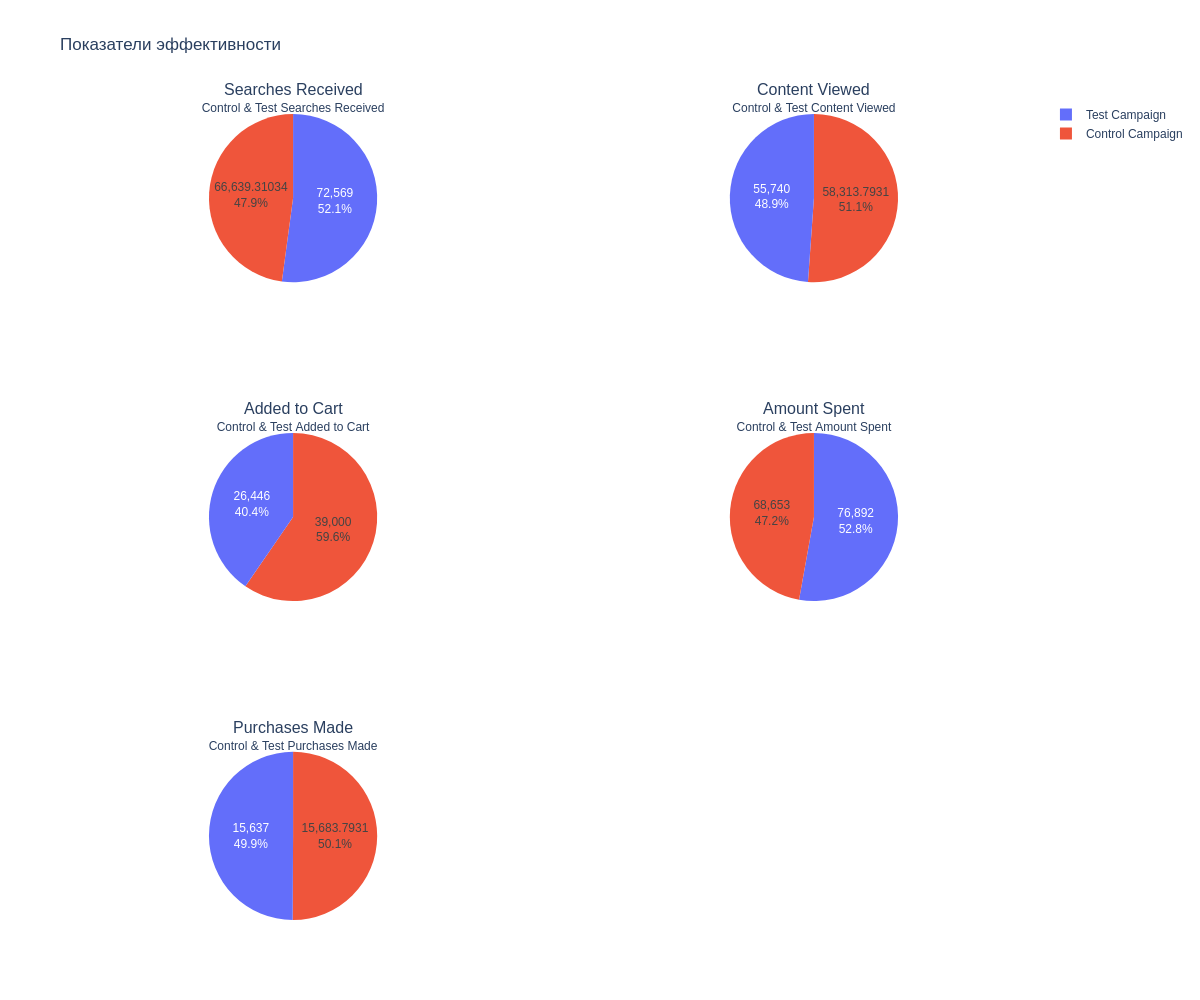

In [46]:
searches_data = ab_data.groupby('Campaign Name')['Searches Received'].sum().reset_index()
content_data = ab_data.groupby('Campaign Name')['Content Viewed'].sum().reset_index()
cart_data = ab_data.groupby('Campaign Name')['Added to Cart'].sum().reset_index()
amount_data = ab_data.groupby('Campaign Name')['Amount Spent'].sum().reset_index()
purchases_data = ab_data.groupby('Campaign Name')['Purchases'].sum().reset_index()

fig_searches = go.Figure(go.Pie(
    labels=searches_data['Campaign Name'],
    values=searches_data['Searches Received'],
    textinfo='percent+value',
    title='Control & Test Searches Received'
))

fig_content = go.Figure(go.Pie(
    labels=content_data['Campaign Name'],
    values=content_data['Content Viewed'],
    textinfo='percent+value',
    title='Control & Test Content Viewed'
))

fig_cart = go.Figure(go.Pie(
    labels=cart_data['Campaign Name'],
    values=cart_data['Added to Cart'],
    textinfo='percent+value',
    title='Control & Test Added to Cart'
))

fig_amount = go.Figure(go.Pie(
    labels=amount_data['Campaign Name'],
    values=amount_data['Amount Spent'],
    textinfo='percent+value',
    title='Control & Test Amount Spent'
))

fig_purchases = go.Figure(go.Pie(
    labels=purchases_data['Campaign Name'],
    values=purchases_data['Purchases'],
    textinfo='percent+value',
    title='Control & Test Purchases Made'
))

fig = make_subplots(rows=3, cols=2, subplot_titles=(
    'Searches Received',
    'Content Viewed',
    'Added to Cart',
    'Amount Spent',
    'Purchases Made'
), specs=[[{'type': 'pie'}, {'type': 'pie'}],
          [{'type': 'pie'}, {'type': 'pie'}],
          [{'type': 'pie'}, {'type': 'pie'}]])


fig.add_trace(fig_searches.data[0], row=1, col=1)
fig.add_trace(fig_content.data[0], row=1, col=2)
fig.add_trace(fig_cart.data[0], row=2, col=1)
fig.add_trace(fig_amount.data[0], row=2, col=2)
fig.add_trace(fig_purchases.data[0], row=3, col=1)

fig.update_layout(title_text="Показатели эффективности",
                  height=1000,
                  width=1200)

fig.show()

* Тестовая кампания привела к увеличению трафика (числа поисковых запросов на веб-сайте).
* Доля просмотренного контента в контрольной группе больше, чем в тестовой.
* Доля добавленных в корзину товаров заметно больше в контрольной группе.
* Доля средств, потраченных на рекламу и маркетинг в тестовой кампании, выше, чем в контрольной.
* Доля сделанных покупок незначительно выше в контрольной группе.

**5. Анализ сглаженных средних**



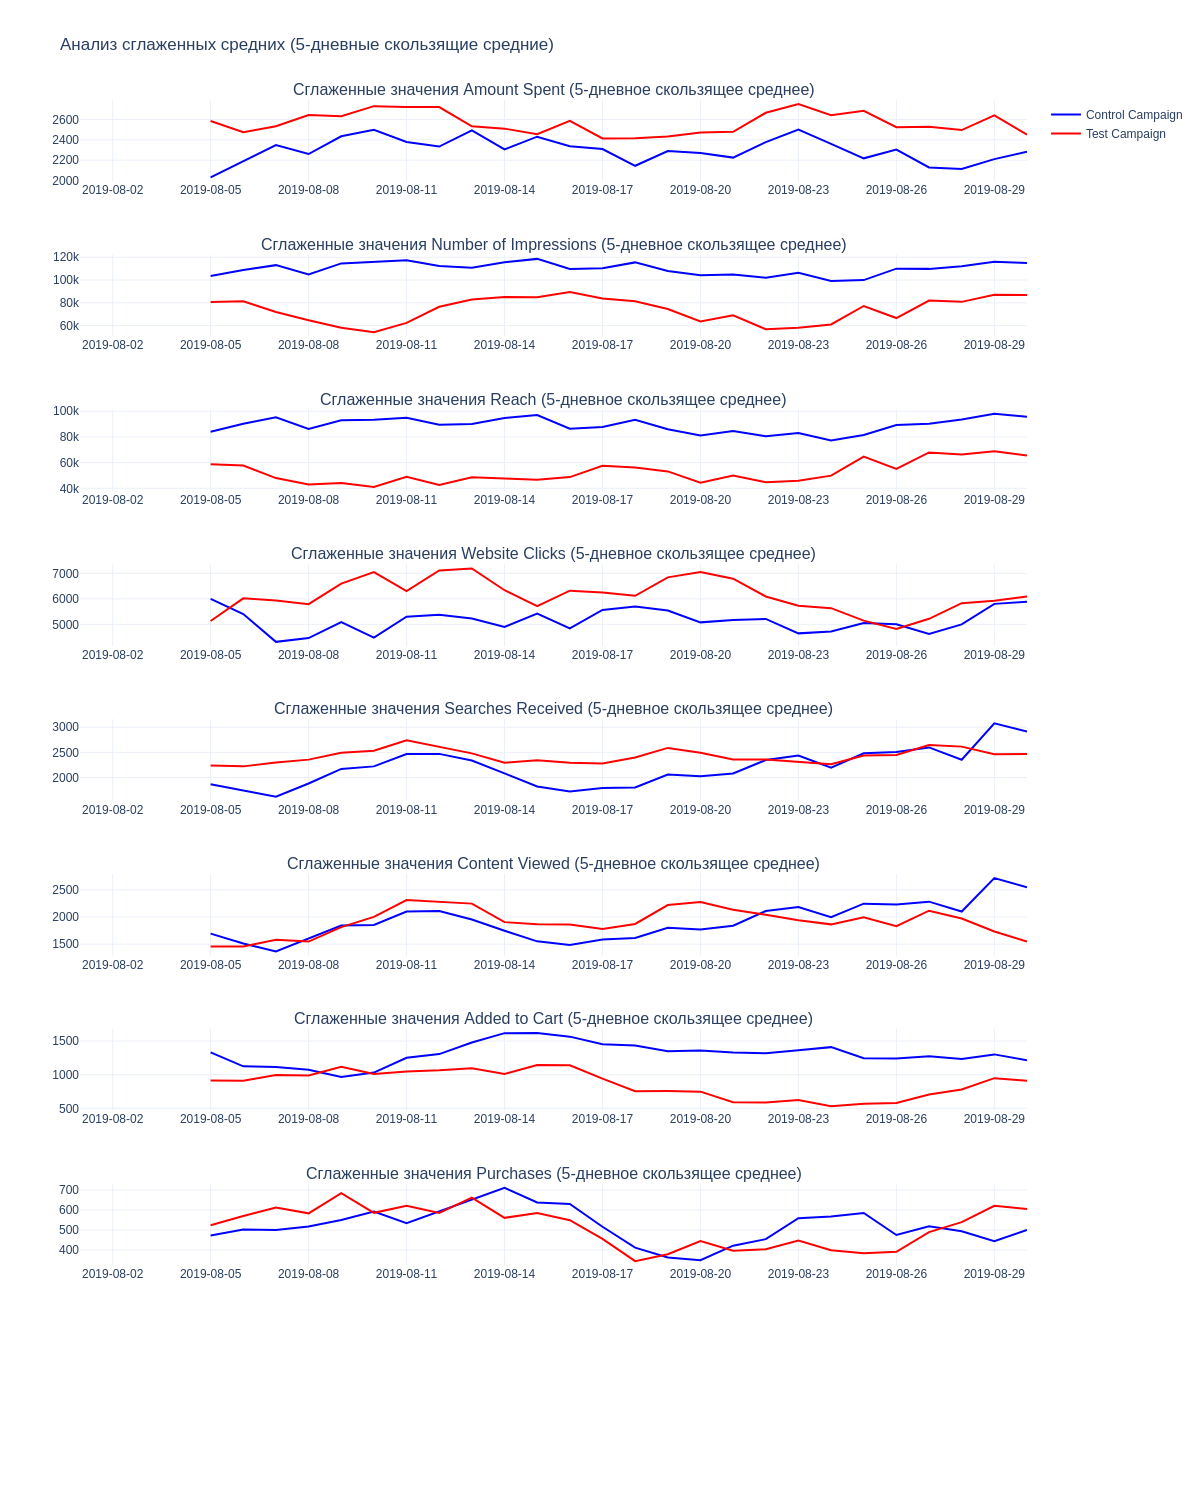

In [47]:
data = ab_data.sort_values(by=['Campaign Name', 'Date'])
columns_for_ma = ['Amount Spent', 'Number of Impressions', 'Reach', 'Website Clicks', 'Searches Received', 'Content Viewed', 'Added to Cart', 'Purchases']

for column in columns_for_ma:
    ma_column_name = f'{column.replace(" ", "_")}_MA_5'
    data[ma_column_name] = data.groupby('Campaign Name')[column].transform(lambda x: x.rolling(window=5).mean())

fig = make_subplots(rows=len(columns_for_ma) + 1, cols=1, shared_xaxes=False,
                    subplot_titles=[f'Сглаженные значения {col} (5-дневное скользящее среднее)' for col in columns_for_ma])

color_map = {'Control Campaign': 'blue', 'Test Campaign': 'red'}

for i, column in enumerate(columns_for_ma):
    ma_column_name = f'{column.replace(" ", "_")}_MA_5'
    for campaign in data['Campaign Name'].unique():
        campaign_data = data[data['Campaign Name'] == campaign]
        fig.add_trace(go.Scatter(x=campaign_data['Date'],
                                 y=campaign_data[ma_column_name],
                                 mode='lines',
                                 name=campaign,
                                 line=dict(color=color_map.get(campaign, 'black')),
                                 showlegend=(i == 0)),
                 row=i+1, col=1)

fig.update_xaxes(tickformat="%Y-%m-%d")
fig.update_layout(height=1500, width=1200, title_text='Анализ сглаженных средних (5-дневные скользящие средние)')

fig.show()

Тестовая кампания выигрывает в:
* количестве кликов по веб-сайту, полученных после рекламы
* количестве пользователей, выполнивших поиск по веб-сайту

Контрольная кампания демонстрирует более высокие и стабильные результаты по многим метрикам.

**6. Расчет конверсий**

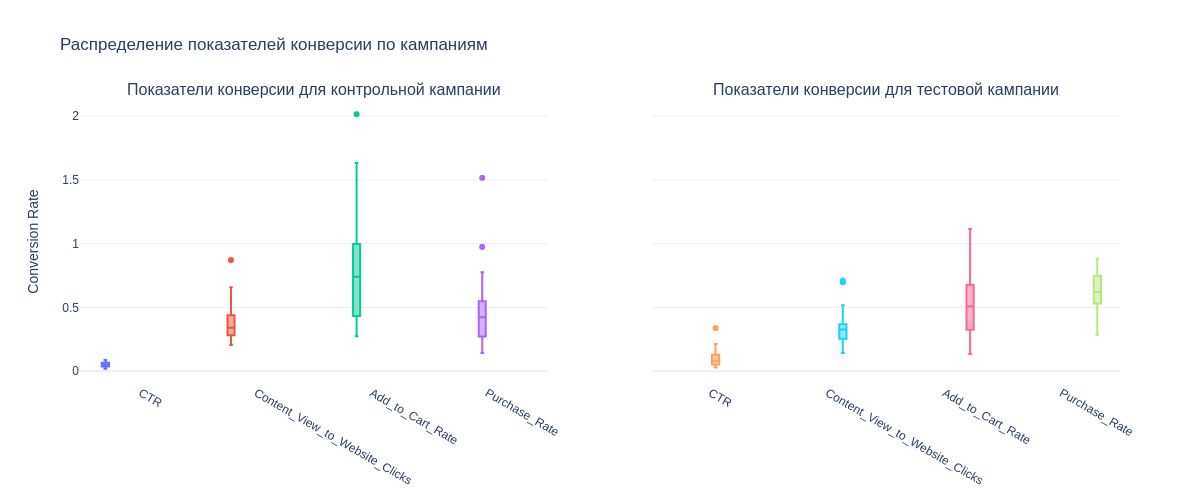

In [48]:
data = ab_data.copy()

data['CTR'] = data['Website Clicks'] / data['Number of Impressions']
data['Content_View_to_Website_Clicks'] = data['Content Viewed'] / data['Website Clicks']
data['Add_to_Cart_Rate'] = data['Added to Cart'] / data['Content Viewed']
data['Purchase_Rate'] = data['Purchases'] / data['Added to Cart']
conversion_metrics = ['CTR', 'Content_View_to_Website_Clicks', 'Add_to_Cart_Rate', 'Purchase_Rate']

fig = make_subplots(rows=1, cols=2,
                    subplot_titles = ('Показатели конверсии для контрольной кампании',
                                      'Показатели конверсии для тестовой кампании'),
                    shared_yaxes=True)
for i, campaign in enumerate(data['Campaign Name'].unique()):
  i+=1
  conversion_data = data[data['Campaign Name'] == campaign]
  for metric in conversion_metrics:
    fig.add_trace(go.Box(y=conversion_data[metric], name=metric), row=1, col=i)

fig.update_layout(
    title='Распределение показателей конверсии по кампаниям',
    yaxis_title='Conversion Rate',
    boxmode='group',
    showlegend=False,
    width=1200
)
fig.show()

* **Click Trough Rate (CTR)**

Tестовая кампания имеет более высокие значения CTR.

* **Доля просмотревших контент среди тех, кто кликнул по веб-сайту благодаря рекламе (Content_View_to_Website_Clicks)**

Показатель в контрольной кампании имеет более широкий диапазон значений и относительно высокий медианный уровень, что указывает на активное взаимодействие пользователей с контентом после посещения сайта.

* **Доля пользователей, добавивших товары в корзину после просмотра контента (Add_to_Cart_Rate)**

Контрольная кампания имеет более высокий процент пользователей, добавивших товары в корзину после просмотра контента.

* **Конверсия от добавления в корзину до покупки (Purchase_Rate)**

Тестовая кампания показывает более высокое медианное значения и лидирует по данной метрике.

# Вывод

Контрольная кампания демонстрирует стабильные и высокие результаты по большинству ключевых метрик, таких как охват, просмотры контента и добавление товаров в корзину. Тестовая кампания, несмотря на меньшее количество показов и охвата, показывает лучшие результаты по показателю кликабельности (CTR) и конверсии от добавления в корзину до покупки.